<h1 style="color:#191970; font-size:38px">MIMO-NN1</h1>

<h1 style="color:#006400">Tools</h1>

<h1 style="color:#FF5733 ; font-size:15px"> CommPy</h1> is an open source toolkit implementing digital communications algorithms in Python using NumPy and SciPy.

In [1]:
pip install scikit-commpy

<h1 style="color:#006400">Libraries</h1>

In [1]:
from statistics import mean
import numpy as np
from numpy.random import *
from numpy import *
from numpy.linalg import inv
from commpy.utilities import *
from commpy.modulation import QAMModem
from commpy.channels import *
from commpy.links import *
from math import *
import matplotlib.pyplot as plt
import time 

<h1 style="color:#006400">Functions</h1>

### 1. High Power Amplifier Output  

In [2]:
def hpa_sspa_modif_rapp(vin,Vsat,p,q,G,A,B):
    A=-345
    a0=abs(vin)
    theta=np.angle(vin)
    Am=(G*a0)/((1+(G*a0/Vsat)**(2*p))**(1/(2*p)))
    Bm=(A*(a0**q))/((1+(a0/B)**(q)))
    vout=Am*np.exp(1j*(theta+Bm))
    return(vout)
    

### 2. Non Linear Distortion Parameters  

In [3]:
def find_K0_sigma2_d(vin,vout):
    K0 = np.mean(vout*np.conj(vin))/np.mean(np.absolute(vin)**2)
    sigma2_d = np.var(vout - K0*vin)
    return(K0,sigma2_d)

<h1 style="color:#006400">Basic PA Non linear Distortion Model </h1>

In [6]:
IBO=3
p=1.1
q=4
Vsat=1.9
G=16
A=-345
B=0.17
val_IBO_m1dB=((1/np.sqrt(10**-0.1))**(2*p)-1)**(1/(2*p))*Vsat/(G)
coeff_IBO_m1dB=val_IBO_m1dB*np.sqrt(10**(-IBO/10))
s=np.random.randn(1,1000000)
vin1 = np.sqrt(1/2)*(s+1j*s)
vin01 = coeff_IBO_m1dB*vin1
a0=np.absolute(vin01)
a02=a0**2  
theta=np.angle(vin01)
Am=(G*a0)/((1+(G*a0/Vsat)**(2*p))**(1/(2*p)))
Bm=(A*(a0**q))/((1+(a0/B)**(q)))
Sm=Am*np.exp(1j*(Bm))
vout1=Am*np.exp(1j*(theta+Bm))
K0 = np.mean(vout1*np.conj(vin01))/np.mean(np.absolute(vin01)**2)
sigma2_d = np.var(vout1 - K0*vin01) 
print(K0)
print(sigma2_d)

(13.724529890387597-0.24702540545627025j)
0.005273746255996075


<h1 style="color:#006400">Training Dataset </h1>

Generate 1000 H; 
For each H, we have 5000 S (input of NN1) and 5000 X_gd (output of NN1)

In [7]:
Mr=10
Mt=100
M=16
SNRdb=600
N_bits=Mr*np.log2(M)
MSE=np.zeros((Mt,50))
x_gd_amp0=np.zeros((Mt,1))
y_gd_r0=np.zeros([Mt,100])
PAPR_GD=np.zeros((Mt,1))
MUIgdi= np.zeros((Mt,1))
SERgdi=np.zeros((Mt,1))
BERgdi=np.zeros((Mt,1))
GD_Execution_time=0
HH=np.zeros((1,2000))
S=np.zeros((11000,20))
ZZ=np.zeros((11000,10),dtype=complex)
Niter=50
mu1=0.0017
lamda=0.00071
mu2=1
eps=1e-2
x_gd=np.zeros([Mt,1])
X_gd=np.zeros((11000,100))
gdx1=np.zeros([Mt,Niter])
d=np.zeros([Mt,1])
X=np.zeros((11000,200))
H=(1/np.sqrt(2*Mt))*(np.random.randn(Mr,Mt)+1j*np.random.randn(Mr,Mt))
HR=H.flatten()
realh=np.real(HR)
imagh=np.imag(HR)
Hr=np.concatenate((realh,imagh),axis=0).reshape(-1,1)
Hr=np.reshape(Hr, (2000, 1)).T
HH=Hr
for j in range(11000):
    bits = np.random.randint(2, size=int(N_bits))
    QAM16 = QAMModem(16)
    z=QAM16.modulate(bits)
    Z = np.reshape(z, (1, 10)).T
    ZZ[j]=Z.T
    reals=np.real(Z.T)
    imags=np.imag(Z.T)
    s=np.concatenate((reals,imags),axis=1)
    S[j]=s
    ## CDm algo
    for i in range(Niter):
        gdx1=2*np.conj(K0*np.transpose(H)).dot(K0*H.dot(x_gd)+H.dot(d)-Z)
        x_gd=x_gd-mu1*gdx1
        realx=np.real( x_gd)
        imagx=np.imag( x_gd)
        x_z=np.concatenate((realx,imagx),axis=0).T
        X[j]=x_z
        ## HPA 
        val_IBO_m1dB=((1/np.sqrt(10**-0.1))**(2*p)-1)**(1/(2*p))*Vsat/(G)
        coeff_IBO_m1dB=val_IBO_m1dB*np.sqrt((1/np.var(x_gd)))*np.sqrt(10**(-IBO/10))
        vin2=coeff_IBO_m1dB*x_gd
        vout2=hpa_sspa_modif_rapp(vin2,Vsat,p,q,G,A,B)
        K0,sigma2_d=find_K0_sigma2_d (vin2,vout2)
        d=vout2-K0*vin2
        y_gd =np.array(vout2/coeff_IBO_m1dB)
print(X)        

[[-0.01708238 -0.02058135 -0.1248105  ...  0.1196112  -0.02955268
   0.06262674]
 [-0.07426327 -0.00488895  0.05883009 ...  0.00682864  0.04032701
  -0.04656127]
 [ 0.04879092  0.00309107 -0.04091963 ...  0.03135259 -0.02896807
  -0.01459549]
 ...
 [ 0.02238798  0.03238247  0.02563201 ...  0.09846181  0.07374631
  -0.04586184]
 [-0.04619295 -0.01814719 -0.05585953 ...  0.00014527  0.02901694
   0.02103972]
 [-0.08611232 -0.0308179   0.0156656  ...  0.03885533 -0.06267606
   0.03491109]]


<h1 style="color:#006400"> Data Normalization </h1>

In [8]:
X_train=S[:8000,:]
y_train=X[:8000,:]

X_test=S[8000:,:]
y_test=X[8000:,:] 


<h1 style="color:#006400"> Artifical Neural Network</h1>

Here owr neural network NN1 for each H
<h1 style="color:#191970; font-size:14px">Input:</h1> 1000 S
<h1 style="color:#191970; font-size:14px">Output:</h1>1000 X_gd
<h1 style="color:#191970; font-size:14px">The activation function selu 'Scaled Exponential Linear' is used for Self-Normalizing Neural Networks </h1>

In [16]:
import keras
from keras.models import Sequential
from keras.layers import Dense,Dropout, Activation, BatchNormalization
import matplotlib.pyplot as plt
model = Sequential()
keras.layers.BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001, center=True, scale=True, beta_initializer='zeros', gamma_initializer='ones', moving_mean_initializer='zeros', moving_variance_initializer='ones', beta_regularizer=None, gamma_regularizer=None, beta_constraint=None, gamma_constraint=None)
keras.optimizers.Adamax(learning_rate=0.9, beta_1=0.999, beta_2=0.999)
model.add(Dense(units =32, kernel_initializer = 'uniform', activation = 'tanh', input_dim =20))
model.add(Dense(units =200, kernel_initializer = 'uniform', activation = 'selu'))
model.compile(optimizer = 'Adamax', loss = 'mse', metrics = ['accuracy'])
history =model.fit(X_train, y_train,validation_data=(X_test, y_test), batch_size=2000, epochs=1000,shuffle=True)


Train on 8000 samples, validate on 3000 samples
Epoch 1/500
8000/8000 [==============================] - 0s 41us/step - loss: 0.0041 - accuracy: 0.0069 - val_loss: 0.0030 - val_accuracy: 0.0160
Epoch 2/500
8000/8000 [==============================] - 0s 11us/step - loss: 0.0027 - accuracy: 0.0223 - val_loss: 0.0023 - val_accuracy: 0.0370
Epoch 3/500
8000/8000 [==============================] - 0s 15us/step - loss: 0.0022 - accuracy: 0.0496 - val_loss: 0.0019 - val_accuracy: 0.0707
Epoch 4/500
8000/8000 [==============================] - 0s 10us/step - loss: 0.0019 - accuracy: 0.0839 - val_loss: 0.0017 - val_accuracy: 0.0920
Epoch 5/500
8000/8000 [==============================] - 0s 9us/step - loss: 0.0016 - accuracy: 0.1098 - val_loss: 0.0015 - val_accuracy: 0.1193
Epoch 6/500
8000/8000 [==============================] - 0s 10us/step - loss: 0.0015 - accuracy: 0.1354 - val_loss: 0.0013 - val_accuracy: 0.1513
Epoch 7/500
8000/8000 [==============================] - 0s 12us/step - loss:

8000/8000 [==============================] - 0s 11us/step - loss: 1.0189e-04 - accuracy: 0.7994 - val_loss: 1.0003e-04 - val_accuracy: 0.8040
Epoch 55/500
8000/8000 [==============================] - 0s 9us/step - loss: 9.8313e-05 - accuracy: 0.8060 - val_loss: 9.6512e-05 - val_accuracy: 0.8107
Epoch 56/500
8000/8000 [==============================] - 0s 9us/step - loss: 9.4850e-05 - accuracy: 0.8134 - val_loss: 9.3086e-05 - val_accuracy: 0.8137
Epoch 57/500
8000/8000 [==============================] - 0s 9us/step - loss: 9.1466e-05 - accuracy: 0.8186 - val_loss: 8.9789e-05 - val_accuracy: 0.8190
Epoch 58/500
8000/8000 [==============================] - 0s 9us/step - loss: 8.8246e-05 - accuracy: 0.8245 - val_loss: 8.6631e-05 - val_accuracy: 0.8240
Epoch 59/500
8000/8000 [==============================] - 0s 9us/step - loss: 8.5180e-05 - accuracy: 0.8305 - val_loss: 8.3643e-05 - val_accuracy: 0.8313
Epoch 60/500
8000/8000 [==============================] - 0s 11us/step - loss: 8.2250e-0

8000/8000 [==============================] - 0s 14us/step - loss: 5.4121e-05 - accuracy: 0.9194 - val_loss: 5.4408e-05 - val_accuracy: 0.9253
Epoch 108/500
8000/8000 [==============================] - 0s 12us/step - loss: 5.4087e-05 - accuracy: 0.9196 - val_loss: 5.4374e-05 - val_accuracy: 0.9253
Epoch 109/500
8000/8000 [==============================] - 0s 11us/step - loss: 5.4055e-05 - accuracy: 0.9197 - val_loss: 5.4344e-05 - val_accuracy: 0.9250
Epoch 110/500
8000/8000 [==============================] - 0s 10us/step - loss: 5.4022e-05 - accuracy: 0.9201 - val_loss: 5.4311e-05 - val_accuracy: 0.9253
Epoch 111/500
8000/8000 [==============================] - 0s 9us/step - loss: 5.3992e-05 - accuracy: 0.9201 - val_loss: 5.4281e-05 - val_accuracy: 0.9257
Epoch 112/500
8000/8000 [==============================] - 0s 10us/step - loss: 5.3963e-05 - accuracy: 0.9208 - val_loss: 5.4250e-05 - val_accuracy: 0.9270
Epoch 113/500
8000/8000 [==============================] - 0s 12us/step - loss:

8000/8000 [==============================] - 0s 13us/step - loss: 5.2141e-05 - accuracy: 0.9304 - val_loss: 5.2396e-05 - val_accuracy: 0.9320
Epoch 212/500
8000/8000 [==============================] - 0s 17us/step - loss: 5.2129e-05 - accuracy: 0.9306 - val_loss: 5.2384e-05 - val_accuracy: 0.9320
Epoch 213/500
8000/8000 [==============================] - 0s 12us/step - loss: 5.2113e-05 - accuracy: 0.9306 - val_loss: 5.2376e-05 - val_accuracy: 0.9313
Epoch 214/500
8000/8000 [==============================] - 0s 12us/step - loss: 5.2102e-05 - accuracy: 0.9304 - val_loss: 5.2357e-05 - val_accuracy: 0.9307
Epoch 215/500
8000/8000 [==============================] - 0s 15us/step - loss: 5.2090e-05 - accuracy: 0.9308 - val_loss: 5.2348e-05 - val_accuracy: 0.9310
Epoch 216/500
8000/8000 [==============================] - 0s 12us/step - loss: 5.2076e-05 - accuracy: 0.9309 - val_loss: 5.2331e-05 - val_accuracy: 0.9320
Epoch 217/500
8000/8000 [==============================] - 0s 10us/step - loss

8000/8000 [==============================] - 0s 10us/step - loss: 5.1088e-05 - accuracy: 0.9366 - val_loss: 5.1318e-05 - val_accuracy: 0.9347
Epoch 316/500
8000/8000 [==============================] - 0s 10us/step - loss: 5.1081e-05 - accuracy: 0.9356 - val_loss: 5.1312e-05 - val_accuracy: 0.9343
Epoch 317/500
8000/8000 [==============================] - 0s 9us/step - loss: 5.1075e-05 - accuracy: 0.9376 - val_loss: 5.1313e-05 - val_accuracy: 0.9347
Epoch 318/500
8000/8000 [==============================] - 0s 9us/step - loss: 5.1066e-05 - accuracy: 0.9359 - val_loss: 5.1299e-05 - val_accuracy: 0.9347
Epoch 319/500
8000/8000 [==============================] - 0s 9us/step - loss: 5.1057e-05 - accuracy: 0.9361 - val_loss: 5.1291e-05 - val_accuracy: 0.9360
Epoch 320/500
8000/8000 [==============================] - 0s 9us/step - loss: 5.1051e-05 - accuracy: 0.9352 - val_loss: 5.1280e-05 - val_accuracy: 0.9350
Epoch 321/500
8000/8000 [==============================] - 0s 10us/step - loss: 5.

8000/8000 [==============================] - 0s 18us/step - loss: 5.0421e-05 - accuracy: 0.9401 - val_loss: 5.0637e-05 - val_accuracy: 0.9387
Epoch 420/500
8000/8000 [==============================] - 0s 13us/step - loss: 5.0421e-05 - accuracy: 0.9398 - val_loss: 5.0633e-05 - val_accuracy: 0.9377
Epoch 421/500
8000/8000 [==============================] - 0s 17us/step - loss: 5.0417e-05 - accuracy: 0.9404 - val_loss: 5.0626e-05 - val_accuracy: 0.9373
Epoch 422/500
8000/8000 [==============================] - 0s 19us/step - loss: 5.0414e-05 - accuracy: 0.9398 - val_loss: 5.0618e-05 - val_accuracy: 0.9367
Epoch 423/500
8000/8000 [==============================] - 0s 13us/step - loss: 5.0407e-05 - accuracy: 0.9391 - val_loss: 5.0613e-05 - val_accuracy: 0.9377
Epoch 424/500
8000/8000 [==============================] - 0s 14us/step - loss: 5.0401e-05 - accuracy: 0.9404 - val_loss: 5.0607e-05 - val_accuracy: 0.9383
Epoch 425/500
8000/8000 [==============================] - 0s 14us/step - loss

<h1 style="color:#006400"> Weights Vector of NN1</h1>

In [24]:
first_layer_weights =model.layers[0].get_weights()[0] 
first=first_layer_weights.flatten()
first_layer_biases  = model.layers[0].get_weights()[1]
first_layer=np.concatenate((first,first_layer_biases),axis=0)
second_layer_weights = model.layers[1].get_weights()[0]
second=second_layer_weights.flatten()
second_layer_biases  = model.layers[1].get_weights()[1]
second_layer=np.concatenate((second,second_layer_biases),axis=0)
weights=np.concatenate((first_layer,second_layer),axis=0)
print (len(weights))

4620


<h1 style="color:#006400"> Make Predictions</h1>

In [17]:
y_pred= model.predict(X_train)

In [18]:
y_pred_test = model.predict(X_test)

In [ ]:
from keras.utils import plot_model
plot_model(model, to_file='model.png')

<h1 style="color:#006400"> Accuracy Representation </h1>

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.grid(True,which="both", linestyle='--')
plt.ylabel('Accuracy') 
plt.xlabel('Epoch')
plt.legend(['Train', 'val'], loc='upper left')
plt.show()

<h1 style="color:#006400"> Loss Representation</h1>

In [ ]:

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.grid(True,which="both", linestyle='--')
plt.ylabel('Loss') 
plt.yscale('log')
plt.xlabel('Epoch')
plt.legend(['Train','val'], loc='upper left')
plt.show()

<h1 style="color:#006400"> Mean-Squared-Error</h1>

# Train Set

Mean Squred Error: -23.418768685707985


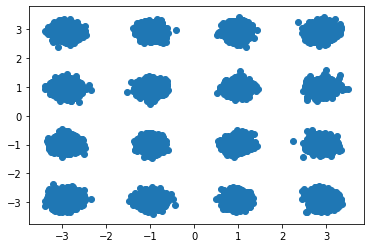

In [21]:
#NMSE_Units=[]
NMSE=np.zeros([5000,1])
recievehh=np.zeros([5000,10],dtype=complex)
Y_gdr=y_pred[:,:100]
Y_gdi=1j*y_pred[:,100:]
Y_gd=Y_gdr+Y_gdi
Shr=X_train[:,:10]
Shi=1j*X_train[:,10:20]
SSh=Shr+Shi
for i in range(5000):
    val_IBO_m1dB=((1/np.sqrt(10**-0.1))**(2*p)-1)**(1/(2*p))*Vsat/(G)
    coeff_IBO_m1dB=val_IBO_m1dB*np.sqrt((1/np.var(Y_gd[i])))*np.sqrt(10**(-IBO/10))
    vin2=coeff_IBO_m1dB*Y_gd[i]
    vout2=hpa_sspa_modif_rapp(vin2,Vsat,p,q,G,A,B)
    Y_gd_amp = vout2/coeff_IBO_m1dB
    recieveh=(H.dot(Y_gd_amp)).reshape((10))
    recievehh[i]=recieveh
    NMSE[i]=(np.mean(np.abs(ZZ[i]-recieveh)**2)/np.mean(np.abs(ZZ[i])**2))
    NMSEdb=10*np.log10(np.mean(NMSE[i]))
recievehhh=recievehh.flatten()
realr=np.real(recievehhh)
imagr=np.imag(recievehhh)
plt.scatter(realr,imagr)    
print('Mean Squred Error:', NMSEdb)


# Test Set 

Mean Squred Error: -23.921055989090263


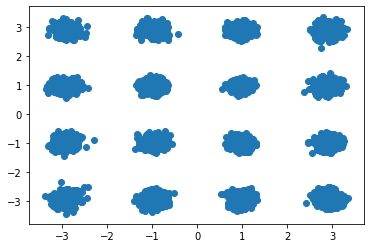

In [14]:
NMSE=np.zeros([1000,1])
recievehh=np.zeros([1000,10],dtype=complex)
Y_gdr=y_pred_test[:,:100]
Y_gdr=y_pred_test[:,:100]
Y_gdi=1j*y_pred_test[:,100:]
Y_gd=Y_gdr+Y_gdi
Shr=X_test[:,:10]
Shi=1j*X_test[:,10:20]
SSh=Shr+Shi
for i in range(1000):
    val_IBO_m1dB=((1/np.sqrt(10**-0.1))**(2*p)-1)**(1/(2*p))*Vsat/(G)
    coeff_IBO_m1dB=val_IBO_m1dB*np.sqrt((1/np.var(Y_gd[i])))*np.sqrt(10**(-IBO/10))
    vin2=coeff_IBO_m1dB*Y_gd[i]
    vout2=hpa_sspa_modif_rapp(vin2,Vsat,p,q,G,A,B)
    Y_gd_amp = vout2/coeff_IBO_m1dB
    recieveh=(H.dot(Y_gd_amp)).reshape((10))
    recievehh[i]=recieveh
    NMSE[i]=(np.mean(np.abs(SSh[i]-recieveh)**2)/np.mean(np.abs(SSh[i])**2))
    NMSEdb=10*np.log10(np.mean(NMSE[i]))
recievehhh=recievehh.flatten()
realr=np.real(recievehhh)
imagr=np.imag(recievehhh)
plt.scatter(realr,imagr)    
print('Mean Squred Error:', NMSEdb)